# Medical Question & Question Type NLP

**Data Sciencist:** Elina Rankova

<div style="width: 100%; text-align: center;">
  <img src="https://altheia.com/wp-content/uploads/2020/12/0KbmpXTpCCIt1TR1B-1280x720.png" width="720" height="450" style="margin: 0 auto;"/>
</div>

<u>image source</u>: <a href="https://altheia.com/recommended-tools-for-data-scientists-in-the-medical-field/">Altheia; Recommended Tools for Data Scientists in the Medical Field</a>

## 1. Business Problem and Understanding

**Stakeholders:** Healing Hands Partners, Lead Receptionist, Lead Nurse, Lead Medical Assistant

Healing Hands medical practice is growing and is noticing that patients are not recieving response to common questions regarding specific diseases in a timely manner. They are interested in automating the Q&A process for both patients and the front desk staff who have a hard time distinguishing where to direct questions.

For Phase 1 of this Natural Language Processing (NLP) task, we will be classifying the questions based on question type, aiming to predict the question type of questions being asked by patients.

**The goal:** Create classification model that predicts question type from which reception can determine who is best equiped to answer patient, improving productivity and patient satisfaction.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
np.random.seed(42)
random.seed(42)
import nltk
from nltk import pos_tag, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import itertools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report,f1_score, RocCurveDisplay, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

## 2. Data Understanding

For this the <a href="https://www.kaggle.com/datasets/thedevastator/comprehensive-medical-q-a-dataset/code">Comprehensive Medical Q&A Dataset</a> sourced from Kaggle.

Our target will the be `qtype` or question type and we will try to match the `Question` column to be able to advice on appropriate next steps accoridng to the type of question being asked.

In [2]:
# Load dataset

df = pd.read_csv('Data/train.csv')
df.head()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


- No missingness to take care of
- 16407 records

In [3]:
df.isna().sum()

qtype       0
Question    0
Answer      0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16407 entries, 0 to 16406
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   qtype     16407 non-null  object
 1   Question  16407 non-null  object
 2   Answer    16407 non-null  object
dtypes: object(3)
memory usage: 384.7+ KB


Looks like our questions address inquiries about specific diseases. This can be applied to help both patients and medical professionals in training with future enhancements to the model.

In [5]:
for qt in df['qtype'].unique():
    # Select the first occurrence of each qtype
    example = df[df['qtype'] == qt].iloc[0]  
    print(example['qtype'],': ',example['Question'])

susceptibility :  Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?
symptoms :  What are the symptoms of Lymphocytic Choriomeningitis (LCM) ?
exams and tests :  How to diagnose Lymphocytic Choriomeningitis (LCM) ?
treatment :  What are the treatments for Lymphocytic Choriomeningitis (LCM) ?
prevention :  How to prevent Lymphocytic Choriomeningitis (LCM) ?
information :  What is (are) Parasites - Cysticercosis ?
frequency :  how common are these diseases for Marine Toxins ?
complications :  are there complications from botulism?
causes :  What causes Chronic Fatigue Syndrome (CFS) ?
research :  what research is being done for Tuberculosis (TB) ?
outlook :  What is the outlook for Striatonigral Degeneration ?
considerations :  What to do for Lactose Intolerance ?
inheritance :  Is Ovarian Epithelial, Fallopian Tube, and Primary Peritoneal Cancer inherited ?
stages :  What are the stages of Ovarian Epithelial, Fallopian Tube, and Primary Peritoneal Cancer ?
genetic changes :  What 

## 3. Data Exploration

### Target Variable `qtype`

Since we have some question types that have very few instances, we will also have to consider our class imbalance when creating our models.

We can also use `LabelEncoder` to transform this variable before the train test split if we choose.

**Note:** There class `support groups` only has one record, if we plan to keep our class proportions when we split our data, we will have to drop this class

Total Label Count: 16 

qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
stages               77
complications        46
support groups        1
Name: count, dtype: int64


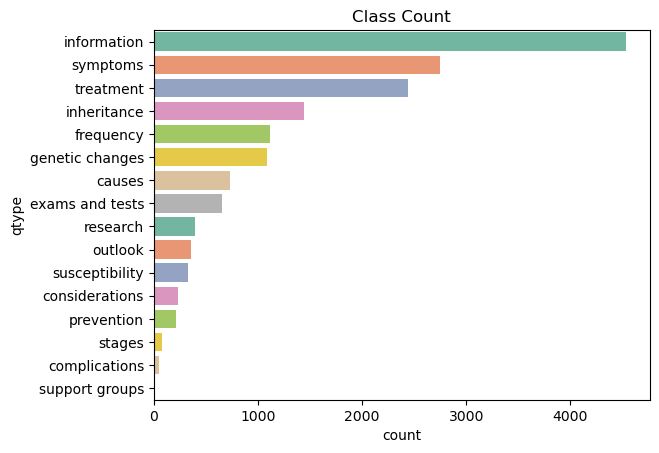

In [6]:
print('Total Label Count:', len(df['qtype'].unique()),'\n')
print(df['qtype'].value_counts())

sns.countplot(df['qtype'],order=df['qtype'].value_counts().index,palette='Set2')
plt.title('Class Count');

### Preprocess Analysis

First, we should take a look at what the word frequency looks like before cleaning our data for things like stopwords and punctuation. It looks like we have a lot of stop words as well as other words that typically would be meaningful but are not in our medical context.

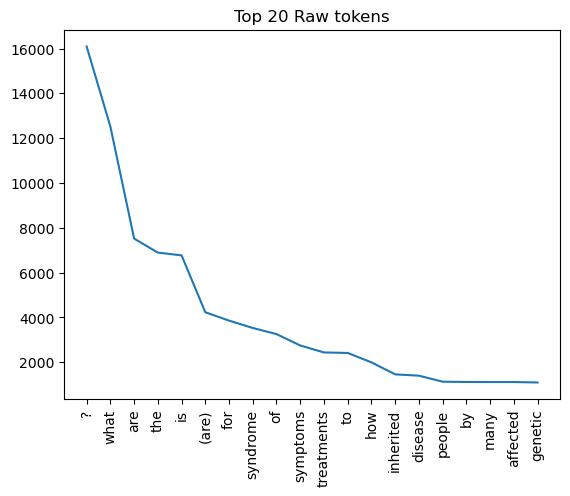

In [7]:
# Unprocessed corpus for Question

corpus = []

for record in df['Question']:
    corpus.extend(record.lower().split(' '))

# Create series
top20words = FreqDist(corpus).most_common(20)
series = pd.Series(dict(top20words))

# Plot series
sns.lineplot(series)
plt.xticks(rotation=90)
plt.title('Top 20 Raw tokens');

Now let's see what our tokens look like after removing stopwords by visualizing them in a wordcloud. It looks like some of the words from our raw token analysis made it into the word cloud giving us an idea of the features we might see after we vectorize.

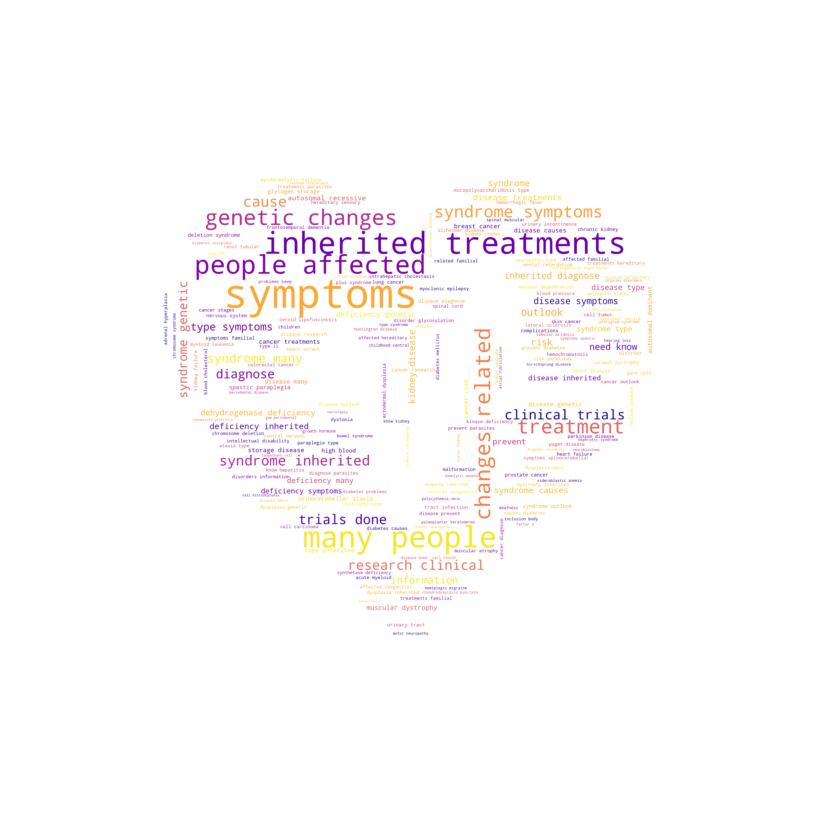

In [8]:
# Define stopwords
stop_words = stopwords.words('english')

# Create clean corpus
corpus_norm = [tok.lower() for word in corpus for tok in 
               word_tokenize(word) if ((tok.isalpha()) & (tok not in stop_words))]
# Define text
text = " ".join(corpus_norm)

# Image mask
mask=np.array(Image.open('Images/Wordcloud Image.jpg'))

# Plot word cloud
plt.figure(figsize=(15,8))
plt.imshow(WordCloud(width=1800,height=1600,background_color='white',
                     mask=mask,colormap='plasma',min_font_size=10).generate_from_text(text),
           interpolation='bilinear')
plt.axis('off')
# Adjust margins to make more space for the word cloud
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout(pad=0);

## 4. Data Preperation

To help us normalize our text, we implemented a `TextPreprocessor class`
- Calls on `BaseEstimator` and `TransformerMixin` to be able to add class into pipeline
- Makes text lowercase
- Tokenizes the text and removes stop words
- Tags with parts of speech
- Lemmatizes the text with `WordNetLemmatizer`

In [9]:
class TextPreprocessor(BaseEstimator, TransformerMixin):

    # BaseEstimator and TransformerMixin are parents enable us to use this class in a pipeline
    # Could have made this into a function and would have to use FunctionTransformer to use in a pipeline
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

Before we split our data, we have to first drop the class with only one record since this interferes with our stratifying the split to keep class distributions consistant.

In [10]:
# Identify index
index_drop = df[df['qtype']=='support groups'].index[0]

df_new = df.copy().drop(index_drop)

X = df_new['Question']
y = df_new['qtype']

# Label encode the target
le = LabelEncoder()
y = le.fit_transform(df_new['qtype'])

# Split train/test data
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

### Base Model Pipeline
As our base model, we will try a `MultinomialNB` model as it is great for text classification problems. Before fitting, we have to add the `TFidVectorizer` to our pipeline to vectorize our text with class weights in mind.

We set our minimum document frequency and maximum document frequency to .03 and .98 respectively to make sure that we don't penalize rare/frequent words too much but also don't loosen the thresholds so much that we create noisy predictions.

In [11]:
# Create preprocess pipeline

prc_steps = [('txtproc',TextPreprocessor()),
             ('tfid',TfidfVectorizer(min_df=.03,max_df=.98)),
             ('model', MultinomialNB())]

init_pipe = Pipeline(steps = prc_steps)

init_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', MultinomialNB())])

_**We are left with 18 features after preprocessing our data in full**_

In [12]:
# Get the feature names from the vectorized X
feat_names = init_pipe['tfid'].get_feature_names_out()

# Pull out transformed X_train and X_test
X_train_trans = init_pipe.named_steps['tfid'].transform(X_train)
X_test_trans=init_pipe.named_steps['tfid'].transform(X_test)

pd.DataFrame(X_train_trans.toarray(),columns=feat_names)

,affect,be,cancer,cause,change,deficiency,diagnose,disease,do,genetic,inherit,many,people,relate,symptoms,syndrome,treatments,type
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.63792,0.636277,0.0,0.000000,0.433831,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,1.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,1.000000,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12299,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.743635,0.668586,0.000000,0.0
12300,0.0,0.0,0.0,0.0,0.0,0.818952,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.573863,0.000000,0.000000,0.0
12301,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.652746,0.757577,0.0
12302,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,1.000000,0.0


Let's also quickly look at our distribution of selected features. Comparing this chart to our wordcloud from earlier, we can see some similarities. Most distinguishing are terms such as 'syndrome' and 'symptoms' which are highly occuring in both. It's also worth noting that due to the medical nature of our NLP task, our selected features remained in their original form after lemmetization.

Feature Distribution:
affect: 0.0
be: 6.0
cancer: 399.3438161500684
cause: 1.0
change: 0.666180191936931
deficiency: 525.1906768962745
diagnose: 448.10422931983584
disease: 897.8754103160874
do: 390.8838596508302
genetic: 720.7282674759
inherit: 0.0
many: 548.9471772356125
people: 554.1238950910567
relate: 0.0
symptoms: 1732.0107985051184
syndrome: 2048.466129154566
treatments: 1567.2476129863874
type: 539.2183223022541


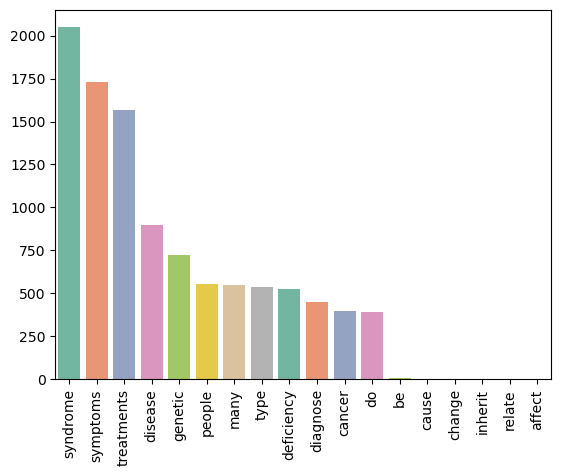

In [13]:
feature_counts = np.sum(X_train_trans.toarray(), axis=0)

feat_series = pd.Series(feature_counts,index=feat_names)

# Print the feature counts
print("Feature Distribution:")
for feature, count in zip(feat_names, feature_counts):
    print(f"{feature}: {count}")

order = feat_series.sort_values(ascending=False)

sns.barplot(feat_series,palette='Set2',order=order.index)
plt.xticks(rotation=90);

## 5. Naive Bayes
Lets check our baseline metrics then move on to cross validation and hyperparameter tuning our base model.

Since we have a class imbalance, we will mostly be focusing on a weighted F1 score. Looking at our classification report our weighted average for F1 looks pretty good. Our precision and recall look pretty great also as a start.

In [14]:
# Baseline score

print('Train Score:', classification_report(y_train,init_pipe.predict(X_train),zero_division=1))

Train Score:               precision    recall  f1-score   support

           0       0.99      1.00      0.99       545
           1       1.00      0.00      0.00        35
           2       1.00      0.00      0.00       176
           3       1.00      1.00      1.00       490
           4       1.00      1.00      1.00       840
           5       1.00      1.00      1.00       815
           6       0.73      1.00      0.84      3401
           7       0.99      1.00      1.00      1084
           8       1.00      0.00      0.00       271
           9       1.00      0.00      0.00       158
          10       1.00      0.00      0.01       296
          11       1.00      0.00      0.00        58
          12       1.00      0.00      0.00       243
          13       1.00      1.00      1.00      2061
          14       1.00      1.00      1.00      1831

    accuracy                           0.90     12304
   macro avg       0.98      0.53      0.52     12304
weighted avg 

Now that we have our base model, we can finetune our `MultiNomialNB` to see if we can improve our scores.

> For each subsequent model we try going forward, we will utilize `RandomizedSearchCV` to tune our parameters and perform cross validation since it is less computationally costy than `GridSearchCV` and will save us some time while giving us direction about our model performance.

In [15]:
# Define your parameter grid
params_init = {
    'model__alpha': [0.1, 1.0, 10.0],
    'model__force_alpha':[True,False],
    'model__fit_prior': [True,False]
    
}

rcv_init=RandomizedSearchCV(init_pipe,param_distributions=params_init,scoring='f1_weighted',
                 return_train_score=True,cv=5,n_iter=12)

rcv_init.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model', MultinomialNB())]),
                   n_iter=12,
                   param_distributions={'model__alpha': [0.1, 1.0, 10.0],
                                        'model__fit_prior': [True, False],
                                        'model__force_alpha': [True, False]},
                   return_train_score=True, scoring='f1_weighted')

In [16]:
# Print parameters of best estimate
rcv_init.best_params_

{'model__force_alpha': True, 'model__fit_prior': True, 'model__alpha': 0.1}

Looks like our F1 on validation and train data did slightly worse than before cross validation and parameter tuning.

In [17]:
# Create quick function to see the scores easier for future models
def rcv_metrics(rcv,model_name,train_df=None):
    best_estimator = rcv.best_estimator_
    score_dict = {'Val Train Score': np.mean(rcv.cv_results_['mean_train_score']),
                 'Val Test Score': np.mean(rcv.cv_results_['mean_test_score']),
                 'Model Name': model_name}
    score_df = pd.DataFrame(score_dict,columns=['Model Name','Val Train Score',
                                                'Val Test Score'], index=range(1))
    if train_df is None:
        pass
    else:
       score_df = pd.concat([train_df,score_df])
       score_df.index = range(len(score_df))
    return score_df, best_estimator
    
train_scores, mnb_best = rcv_metrics(rcv_init,'MultiNB')
train_scores

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928


Looks like we did a lot better on the full train and test data. This is a good starting point.

,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105


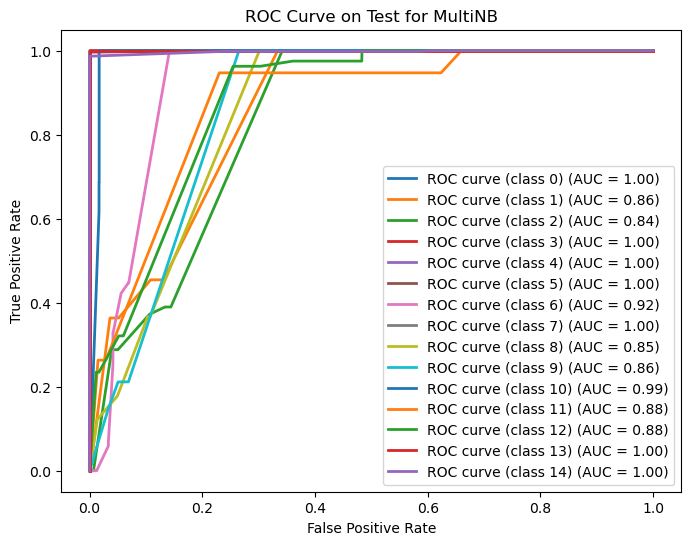

In [18]:
# Function to dislay f1 score and confusion matrix
def test_metrics(model,model_name,test_df=None):

    # Define score dictionary
    score_dict = {'Model Name':model_name,
                  'Train Score': f1_score(y_train,model.predict(X_train),average='weighted'),
                  'Test Score': f1_score(y_test, model.predict(X_test),average='weighted')}
    score_df=pd.DataFrame(score_dict,columns=['Model Name','Train Score','Test Score'],index=range(1))

    # Return new dataframe or concat 
    if test_df is None:
        pass
    else:
       score_df = pd.concat([test_df,score_df])
       score_df.index = range(len(score_df))
       score_df.sort_values(by='Test Score', inplace=True, ascending=False)

    # Display the dataframe
    display(score_df)
    
    # Get probabilities of each class
    y_proba = model.predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    plt.figure(figsize=(8, 6))
    lw = 2
    for i in range(len(set(y_test))):
        fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve on Test for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return score_df
    

# Predict on the test
test_scores = test_metrics(mnb_best,'MultiNB')

### Complement Naive Bayes

Since we know we have class imblance, lets see if this modification to Multinomial Naive Bayes can help improve our score for this model.

In [19]:
# Replace in pipeline

cnb_pipe = init_pipe.set_params(model=ComplementNB())
cnb_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', ComplementNB())])

In [20]:
# Randomizedsearch CV 

params_cnb = {'model__alpha': [0.1, 1.0, 10.0],
              'model__force_alpha':[True,False],
              'model__fit_prior': [True,False]
    
}

rcv_cnb = RandomizedSearchCV(cnb_pipe,param_distributions=params_cnb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=12)

rcv_cnb.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model', ComplementNB())]),
                   n_iter=12,
                   param_distributions={'model__alpha': [0.1, 1.0, 10.0],
                                        'model__fit_prior': [True, False],
                                        'model__force_alpha': [True, False]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [21]:
# Print parameters of best estimate
rcv_cnb.best_params_

{'model__force_alpha': True, 'model__fit_prior': True, 'model__alpha': 0.1}

Unfortunately, this version of Naive Bayes did even worse than our Multinomial model. This is demonstrated in the score and test set ROC Curve

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,ComplementNB,0.735281,0.733771


,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105
1,ComplementNB,0.733154,0.742919


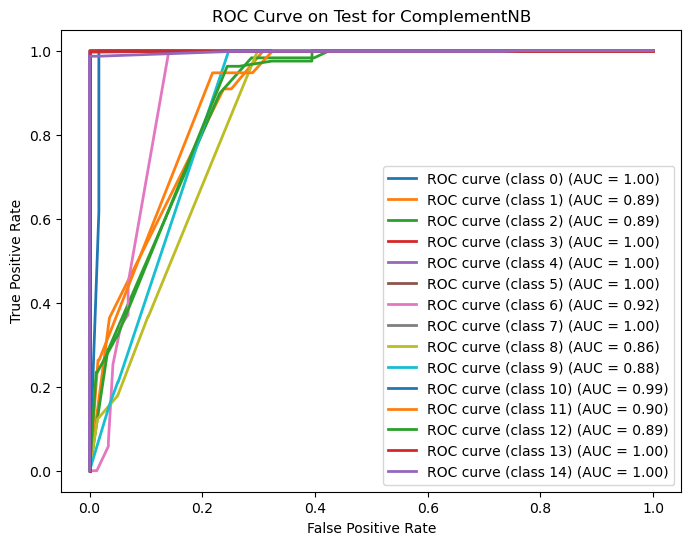

In [22]:
# Get train and test metrics
train_scores, cnb_best = rcv_metrics(rcv_cnb,'ComplementNB',train_scores)
display(train_scores)

test_scores = test_metrics(cnb_best,'ComplementNB',test_scores)

## 6. Tree Models

Next we will try some decision tree algorithms, starting with a simple `DecisionTreeClassifier`.

### DecisionTree

In [23]:
# Replace in pipeline

dec_pipe = init_pipe.set_params(model=DecisionTreeClassifier())
dec_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', DecisionTreeClassifier())])

In [24]:
# Randomizedsearch CV 

params_dec = {'model__criterion': ['gini','entropy','log_loss'],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'model__min_samples_split': [2, 5, 10, 20, 50],
          'model__class_weight': [None,'balanced'],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv_dec = RandomizedSearchCV(dec_pipe,param_distributions=params_dec,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_dec.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model',
                                              DecisionTreeClassifier())]),
                   n_iter=15,
                   param_distributions={'model__class_weight': [None,
                                                                'balanced'],
                                        'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20, 50]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [25]:
# Print parameters of best estimate
rcv_dec.best_params_

{'model__min_samples_split': 5,
 'model__min_samples_leaf': 1,
 'model__max_depth': 8,
 'model__criterion': 'entropy',
 'model__class_weight': None}

So far, our decision tree is providin the best results on our unseen data! This could be due to the type of questions we have and their formulaic nature in relation to the `qtype`.

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,ComplementNB,0.735281,0.733771
2,Decision,0.688695,0.688522


,Model Name,Train Score,Test Score
2,Decision,0.873223,0.873457
0,MultiNB,0.855172,0.853105
1,ComplementNB,0.733154,0.742919


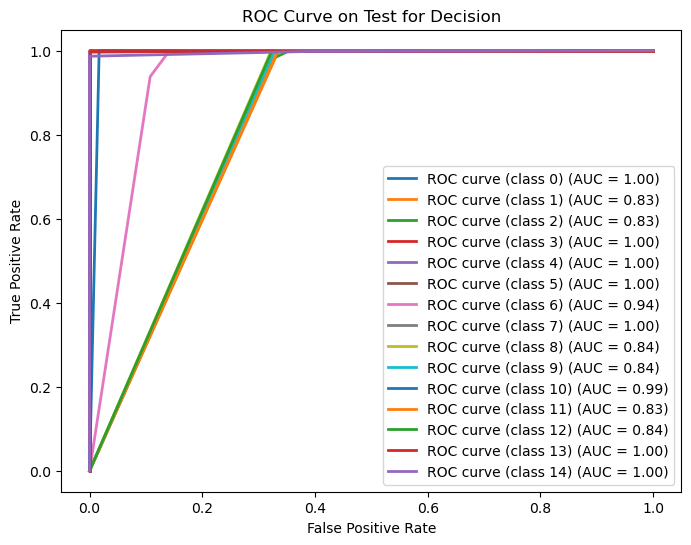

In [26]:
# Get train and test metrics
train_scores, dec_best = rcv_metrics(rcv_dec,'Decision',train_scores)
display(train_scores)

test_scores = test_metrics(dec_best,'Decision',test_scores)

### RandomForest

In [27]:
# Replace in pipeline

forest_pipe = init_pipe.set_params(model=RandomForestClassifier())
forest_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', RandomForestClassifier())])

In [28]:
# Randomizedsearch CV 

params_forest = {'model__criterion': ['gini','entropy','log_loss'],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'model__min_samples_split': [2, 5, 10, 20, 50],
          'model__class_weight': ['balanced_subsample','balanced'],
          'model__max_features': ['sqrt','log2',None],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv_forest = RandomizedSearchCV(forest_pipe,param_distributions=params_forest,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_forest.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_iter=15,
                   param_distributions={'model__class_weight': ['balanced_subsample',
                                                                'balanced'],
                                        'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20, 50]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [29]:
# Print parameters of best estimate
rcv_forest.best_params_

{'model__min_samples_split': 5,
 'model__min_samples_leaf': 5,
 'model__max_features': None,
 'model__max_depth': 10,
 'model__criterion': 'entropy',
 'model__class_weight': 'balanced'}

The random forest performed worse than all models so far on unseen data and validation data. This could be due to a fairly small dataset and class imbalance.

Though, it looks like our ROC curve on par with our `MultiNomialNB` model.

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,ComplementNB,0.735281,0.733771
2,Decision,0.688695,0.688522
3,Forest,0.700085,0.699713


,Model Name,Train Score,Test Score
0,Decision,0.873223,0.873457
1,MultiNB,0.855172,0.853105
2,ComplementNB,0.733154,0.742919
3,Forest,0.723741,0.729931


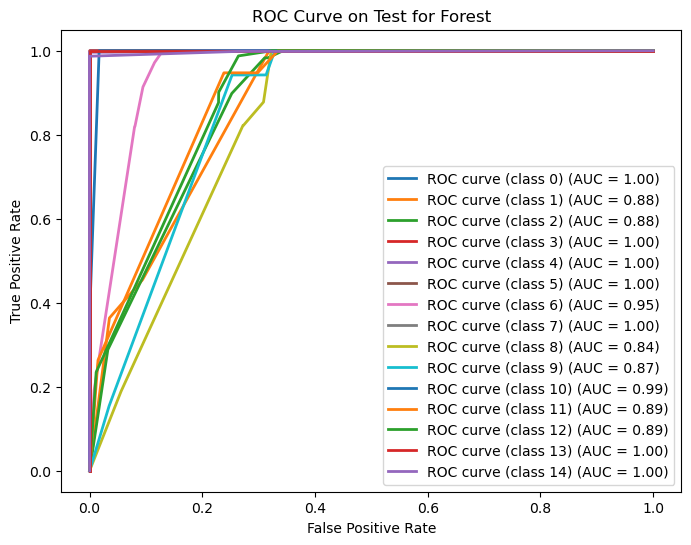

In [30]:
# Get train and test metrics
train_scores, forest_best = rcv_metrics(rcv_forest,'Forest',train_scores)
display(train_scores)

test_scores = test_metrics(forest_best,'Forest',test_scores)

## 7. Boosting Models

Since cost sensitive learning could help us with or class imbalance, we should try some models to see if we can get our score higher.

### GradientBoost

In [31]:
# Replace in pipeline

gb_pipe = init_pipe.set_params(model=GradientBoostingClassifier())
gb_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', GradientBoostingClassifier())])

In [ ]:
# Randomizedsearch CV 

params_gb = {'model__max_depth': [3, 4, 6, 8, 10],
          'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'model__n_estimators': [100, 200, 500, 1000],
          'model__min_samples_split':  [2, 5, 10, 20, 50],
          'model__max_features': ['sqrt','log2',None],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__min_samples_leaf': [1, 2, 5, 10]
          
}

rcv_gb = RandomizedSearchCV(gb_pipe,param_distributions=params_gb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_gb.fit(X_train,y_train)

In [ ]:
# Print parameters of best estimate
rcv_gb.best_params_

When looking at our full train and test, the GradientBoost looks to have performed just about as well as our decision tree. 

In [ ]:
# Get train and test metrics
train_scores, gb_best = rcv_metrics(rcv_gb,'GradientBoost',train_scores)
display(train_scores)

test_scores = test_metrics(gb_best,'GradientBoost',test_scores)

### XGBoost

In [ ]:
# Replace in pipeline

xgb_pipe = init_pipe.set_params(model=XGBClassifier())
xgb_pipe.fit(X_train,y_train)

In [ ]:
# Randomizedsearch CV 

params_xgb = {'model__learning_rate':  [0.01, 0.05, 0.1, 0.3, 0.5],
          'model__n_estimators': [100, 500, 1000, 2000, 3000],
          'model__min_child_weight':  [1,5,10,20,50],
          'model__colsample_bytree': [0.5, 0.75, 1.0],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
          'model__reg_alpha':  [0, 0.001, 0.01, 0.1, 1, 10],
          'model__reg_lambda':  [0, 0.001, 0.01, 0.1, 1, 10],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

rcv_xgb = RandomizedSearchCV(xgb_pipe,param_distributions=params_xgb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=10)

rcv_xgb.fit(X_train,y_train)

In [ ]:
# Print parameters of best estimate
rcv_xgb.best_params_

In [ ]:
# Get train and test metrics
train_scores, xgb_best = rcv_metrics(rcv_xgb,'XGBoost',train_scores)
display(train_scores)

test_scores = test_metrics(xgb_best,'XGBoost',test_scores)

### AdaBoost

In [ ]:
# Replace in pipeline

ada_pipe = init_pipe.set_params(model=AdaBoostClassifier(algorithm='SAMME'))
ada_pipe.fit(X_train,y_train)

In [ ]:
# Randomizedsearch CV 

params_ada = {'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'model__n_estimators': [50, 100, 200, 500, 1000]
}

rcv_ada = RandomizedSearchCV(ada_pipe,param_distributions=params_ada,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_ada.fit(X_train,y_train)

In [ ]:
# Print parameters of best estimate
rcv_ada.best_params_

In [ ]:
# Get train and test metrics
train_scores, ada_best = rcv_metrics(rcv_ada,'AdaBoost',train_scores)
display(train_scores)

test_scores = test_metrics(ada_best,'AdaBoost',test_scores)

## 8. Best Model Evaluation

Since our DecisionTree and AdaBoost are so close in F1 scores, we should compare the two further to make sure we are making wholistic decision when it comes to our predictive model.

When we look at the feature importances of both models, the similarity between the two is further confirmed. They are both demonstrating the same top 10 features at very similar levels!

In [ ]:
# Define feature importances
feature_importances = dec_best['model'].feature_importances_
feature_importances = ada_best['model'].feature_importances_

# Define and Display full series with feature importance
dec_feat_imp = pd.Series(feature_importances,dec_best['tfid'].get_feature_names_out())
ada_feat_imp = pd.Series(feature_importances,ada_best['tfid'].get_feature_names_out())

# Get top 10 features
dec_feat10 = dec_feat_imp.sort_values(ascending=False).nlargest(10)
ada_feat10 = ada_feat_imp.sort_values(ascending=False).nlargest(10)

fig, ax = plt.subplots(figsize=(12,8),ncols=2)
sns.barplot(x=dec_feat10.values,y=dec_feat10.index,ax=ax[0],palette='Set3')
sns.barplot(x=ada_feat10.values,y=ada_feat10.index,ax=ax[1],palette='Set3')
ax[0].set_title("Top 10 Feature Importances DecisionTree")
ax[1].set_title("Top 10 Feature Importances AdaBoost")
ax[0].set_xlabel('Importance')
ax[1].set_xlabel('Importance')
ax[0].set_ylabel('Feature')
ax[1].set_ylabel('Feature')
plt.tight_layout();

Looking at our classification report we can tell that the `AdaBoostingClassifier` while doing mostly as well as the `DecisionTreeClassifier`, it has better scores for accuracy, recall, and precision. This means that it is balancing false negatives and false positives well and producing largly accurate predictions for us!

Lastly we should compare our tuned `AdaBoostingClassifier` above and the base `AdaBoostingClassifier` model we started. 

In [ ]:
print('DecisionTree Classification Report\n',classification_report(y_test,dec_best.predict(X_test),
                                                                   zero_division=1))
print('AdaBoost Classification Report\n',classification_report(y_test,gb_best.predict(X_test),
                                                                    zero_division=1))

Looks like we have a great improvement! Before tuning and cross validation, our base `AdaBoostingClassifier` did even worse than our original `MultiNomialNB`.

In [ ]:
print('Base AdaBoost Classification Report\n', classification_report(y_test,ada_pipe.predict(X_test)))

## 9. Final Evaluation & Conclusion

Based on a wholistic evaluation, we can conclude that the `AdaBoostingClassifier` provides us with the best results and overall most reliable predictions. This model not only has a comprable F1 score to our `DecisionTreeClassifier` but does better in the other relevant metrics, making it the overall best choice.

**Recommendations:**

For _<ins>Phase 1</ins>_ of this NLP task, we recommend implementing the model for the front desk staff, where the Healing Hands team can coordinate around a process that pairs predicted class with the corresponding best professional equipped to answer these patient inquiries. This process can be implemented via phone, email, and SMS - routing the questions based on their predicted subject.

**Positive Implications:** 

Since the metrics are strong, we can be confident in routing questions to the right person, making the patient care more efficient for both the office staff and patients alike.

**Negative Implications:**

The model is not perfect, and there will be the rare occasion that a question is paired with the wrong class. In such cases, the office staff should align on protocol so that patients are not provided misleading medical advice. Data on these instances should also be collected for future iterations.

**Data Limitation and Future Considerations:**

As seen in our exploration, our dataset is limited in record number as well as the amount of records available in each class. For future improvements, we would recommend to collect more data on both questions, answers, and associated categories to further improve model reliability.

In addition, by increasing the amount of available data, our model can afford to add more strict constraints on minimum and maximum document frequency of tokens. This will make our predictions stronger and create a strong baseline to expand on how we use this information.

Ultimately, Healing Hands would like to implement a Retrieval-Augmented Generation (RAG) chatbot. This chatbot would enable patients and potentially medical staff to not only recieve the general category of the questions being asked, but an answer to those questions well, all based on similarity metrics created from existing data. Since Healing Hands is first and foremost concerned about their patients satisfaction and wellbeing, this chatbot can be implemented where appropriate and provide an option to speak to a person if the patient so chooses.